<h1 style="color: #00BFFF;">00 |</h1>

In [2]:
# 📚 Basic libraries
import os # file access
import matplotlib.pyplot as plt #  visualization
import numpy as np # image numeric array manipulation
import shutil # folder operations
import random # shuffle data

# ⚙️ Settings
import warnings # who likes warnings?
warnings.filterwarnings('ignore') # ignore warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # ignoring AVX warning from tensorflow

# 🌐 Computer Vision
import cv2 # image reading
from tensorflow import keras # deep learning and neural networks
from tensorflow.keras.preprocessing.image import ImageDataGenerator # data augmentation
from tensorflow.keras.utils import img_to_array, array_to_img, load_img # saving augmented Data
from tensorflow.keras import layers, Model # neural network and model
from keras.models import load_model

In [3]:
# 🎯 Specific Functions
def augment_images(data_dir, datagen, num_images=5):
    for filename in os.listdir(data_dir):
        if filename.endswith(".jpeg"):
            img_path = os.path.join(data_dir, filename)
            img_array = img_to_array(load_img(img_path))  # converting the image to numpy array
            img_array = img_array.reshape((1,) + img_array.shape)  # reshape the data

            # Generate new images
            for i, _ in enumerate(datagen.flow(img_array, batch_size=1, save_to_dir=data_dir, save_prefix='aug', save_format='jpeg')):
                if i >= num_images - 1:
                    break
                    
def unet_model(input_shape): # adapted from Keras
    inputs = layers.Input(shape=input_shape)
    
    # Entry block
    x = keras.layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual
    
    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = keras.layers.Activation("relu")(x)
        x = keras.layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = keras.layers.BatchNormalization()(x)

        x = keras.layers.Activation("relu")(x)
        x = keras.layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = keras.layers.BatchNormalization()(x)

        x = keras.layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = keras.layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = keras.layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual
        
    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = keras.layers.Activation("relu")(x)
        x = keras.layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = keras.layers.BatchNormalization()(x)

        x = keras.layers.Activation("relu")(x)
        x = keras.layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = keras.layers.BatchNormalization()(x)

        x = keras.layers.UpSampling2D(2)(x)

        # Project residual
        residual = keras.layers.UpSampling2D(2)(previous_block_activation)
        residual = keras.layers.Conv2D(filters, 1, padding="same")(residual)
        x = keras.layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual
        
    # Add a per-pixel classification layer
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model

<h1 style="color: #00BFFF;">01 | Data Extraction</h1>

This public hand dataset contains different folders (numeric) with two subfolders: no_bg and original.

The goal is to segment hands from unseen data with high precision.

In [4]:
data_path = os.path.join(os.path.expanduser("~"), "Documents", "1_projects", "01_hands", "01_data")

<h1 style="color: #00BFFF;">02 | Data Cleaning</h1>

For full Data Cleaning Process documentation, refer to 02_new_prototype python script.

In [5]:
# folders for clean images:
original_clean_path = os.path.join(data_path, '00_original_clean')
no_bg_clean_path = os.path.join(data_path, '00_no_bg_clean')

<h3 style="color: #008080;">Training, Validation and Test</h3>

In [6]:
# original and mask directories for test
test_dir = os.path.join(data_path, "03_test")

# original and mask directories for train and validation
train_dir = os.path.join(data_path, "01_train")
val_dir = os.path.join(data_path, "02_validation")

<h4 style="color: #008080;">Training, Validation and Test split</h3>

For this model, we use (as in 02_new_prototype python script):
* 65% Data for Training (it'll be augmented)
* 25% Data for Validation
* 10% Data for Testing

<h3 style="color: #008080;">Debugging ImageDataGenerator</h3>

ImageDataGenerator wasn't detecting images. They need to be in subfolders.

In [7]:
train_original_dir = os.path.join(train_dir, "original")
train_mask_dir = os.path.join(train_dir, "mask")

val_original_dir = os.path.join(val_dir, "original")
val_mask_dir = os.path.join(val_dir, "mask")

test_original_dir = os.path.join(test_dir, "original")
test_mask_dir = os.path.join(test_dir, "mask")

<h1 style="color: #00BFFF;">03 | Data Pre-Processing</h1>

<h3 style="color: #008080;">Noise Reduction</h3>

Bilateral Filtering:

In [38]:
def apply_denoising(img):
    # Bilateral Filteringç
    bilateral = cv2.bilateralFilter(img, 9, 75, 75)
    return bilateral

<h3 style="color: #008080;">Histogram Equalization</h3>

CLAHE:

In [39]:
def enhance_contrast(img):
    # if the image is grayscale or not. If not, convert it.
    if len(img.shape) == 3 and img.shape[2] == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray = img

    gray = np.uint8(gray)
    
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8)) # applying CLAHE
    clahe_img = clahe.apply(gray)
    
    return clahe_img

<h3 style="color: #008080;">Edge Detection</h3>

Canny Edges:

In [40]:
def canny_edge_detector(img):
    # if the image is already grayscale. If not, convert it.
    if len(img.shape) == 3 and img.shape[2] == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray = img
    
    edges_canny = cv2.Canny(gray, 50, 150) # canny edges
    
    return edges_canny

<h3 style="color: #008080;">Morphological Operations:</h3>

Dilatation:

In [45]:
def apply_dilation(img, kernel_size=5, iterations=1):
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    dilation = cv2.dilate(img, kernel, iterations=iterations)
    return dilation

<h3 style="color: #008080;">All pre-processing methods:</h3>

In [60]:
def custom_preprocessing(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Load the grayscale image first
    denoised_img = apply_denoising(img)
    clahe_img = enhance_contrast(denoised_img)
    edges = canny_edge_detector(clahe_img)
    dilation_img = apply_dilation(edges)    
    return dilation_img.astype(np.uint8)

In [61]:
original_folder = os.path.join(train_original_dir, "sub_original")

In [62]:
test_image = os.path.join(original_folder, "hand_5620114802.jpeg")

In [63]:
# Load your image and preprocess
binary_image = custom_preprocessing(test_image)

In [64]:
# Find connected components
num_labels, labels = cv2.connectedComponents(binary_image)

# Compute area of each component. Ignore the first component which is the background.
area = [np.sum(labels == i) for i in range(1, num_labels)]

# Get the index of the largest component
largest_component_index = area.index(max(area)) + 1

# Create the mask
mask = np.where(labels == largest_component_index, 255, 0).astype('uint8')

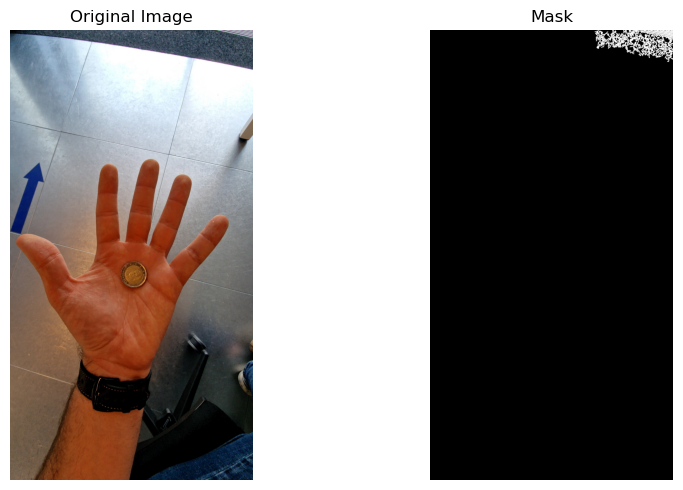

In [65]:
# Load the original image
original_image = cv2.imread(test_image)
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB for correct visualization with matplotlib

plt.figure(figsize=(10, 5))

# Plot the original image
plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title("Original Image")
plt.axis('off')  # Hide the axis values

# Plot the mask
plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')
plt.title("Mask")
plt.axis('off')

plt.tight_layout()
plt.show()

<h3 style="color: #008080;">Pixel Normalization + Pre-Processing</h3>

In [10]:
train_image_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=custom_preprocessing)
train_mask_datagen = ImageDataGenerator(rescale=1./255) # masks without pre-processing techniques

val_image_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=custom_preprocessing)
val_mask_datagen = ImageDataGenerator(rescale=1./255)

test_image_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=custom_preprocessing)
test_mask_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
import cv2
import numpy as np

# Load your binary image (after preprocessing)
binary_image = cv2.imread("path_to_image.jpg", cv2.IMREAD_GRAYSCALE)

# Find connected components
num_labels, labels = cv2.connectedComponents(binary_image)

# Compute area of each component. Ignore the first component which is the background.
area = [np.sum(labels == i) for i in range(1, num_labels)]

# Get the index of the largest component
largest_component_index = area.index(max(area)) + 1

# Create the mask
mask = np.where(labels == largest_component_index, 255, 0).astype('uint8')

<h2 style="color: #00BFFF;">Data Augmentation</h3>

For full Data Augmentation process, refer to 02_new_protype python script

<h1 style="color: #00BFFF;">04 | Modeling</h1>

<h3 style="color: #008080;">Fine-Tunning the Model</h3>

In [11]:
# Parameters that we can fine-tune later on
img_height = 480
img_width = 272
image_size = (img_height, img_width)
batch_size = 8

<h3 style="color: #008080;">Train and Validation Data</h3>

In [12]:
train_image_gen = train_image_datagen.flow_from_directory(
    train_original_dir,
    class_mode=None,
    seed=1337,
    target_size=image_size,
    batch_size=batch_size,
    shuffle=False
)

train_mask_gen = train_mask_datagen.flow_from_directory(
    train_mask_dir,
    class_mode=None,
    seed=1337,
    target_size=image_size,
    batch_size=batch_size,
    color_mode="grayscale",
    shuffle=False
)

Found 303 images belonging to 1 classes.
Found 303 images belonging to 1 classes.


In [13]:
X_train = zip(train_image_gen, train_mask_gen)

In [14]:
val_image_gen = val_image_datagen.flow_from_directory(
    val_original_dir,
    class_mode=None,
    seed=1337,
    target_size=image_size,
    batch_size=batch_size,
    shuffle=False
)

val_mask_gen = val_mask_datagen.flow_from_directory(
    val_mask_dir,
    class_mode=None,
    seed=1337,
    target_size=image_size,
    batch_size=batch_size,
    color_mode="grayscale",
    shuffle=False
)

Found 19 images belonging to 1 classes.
Found 19 images belonging to 1 classes.


In [15]:
x_val = zip(val_image_gen, val_mask_gen)

<h3 style="color: #008080;">Model Build</h3>

In [16]:
model = unet_model(input_shape=(img_height, img_width, 3))

<h3 style="color: #008080;">Hyperparameters</h3>

In [17]:
model.compile(
    optimizer=keras.optimizers.Adamax(learning_rate=0.01),
    loss="binary_crossentropy",
    metrics=["accuracy", keras.metrics.MeanIoU(num_classes=2)]
)

<h3 style="color: #008080;">Epochs</h3>

In [18]:
X_train_steps = len(train_image_gen)
x_val_steps = len(val_image_gen)

epochs = 30

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,  # my patience for this
    verbose=1,
    restore_best_weights=True 
)

<h3 style="color: #008080;">Check Points</h3>

In [19]:
checkpoints = os.path.join(data_path, "04_epochs", "save_at_II_{epoch}.keras")

callbacks = [
    keras.callbacks.ModelCheckpoint(checkpoints),
    early_stopping
]

<h3 style="color: #008080;">Deep Learning</h3>

In [20]:
history = model.fit(
    x=X_train,
    epochs=epochs, 
    steps_per_epoch=X_train_steps,
    validation_data=x_val,
    validation_steps=x_val_steps,
    callbacks=callbacks
)

Epoch 1/30
38/38 [==============================] - 634s 16s/step - loss: 2.5127 - accuracy: 0.6627 - mean_io_u: 0.3875 - val_loss: 0.6664 - val_accuracy: 0.7269 - val_mean_io_u: 0.3676
Epoch 2/30
38/38 [==============================] - 4674s 126s/step - loss: 0.5805 - accuracy: 0.7461 - mean_io_u: 0.3835 - val_loss: 0.5955 - val_accuracy: 0.7298 - val_mean_io_u: 0.3676
Epoch 3/30
38/38 [==============================] - 3769s 100s/step - loss: 0.5674 - accuracy: 0.7489 - mean_io_u: 0.3835 - val_loss: 0.5928 - val_accuracy: 0.7298 - val_mean_io_u: 0.3676
Epoch 4/30
38/38 [==============================] - 3091s 83s/step - loss: 0.5594 - accuracy: 0.7491 - mean_io_u: 0.3835 - val_loss: 0.5807 - val_accuracy: 0.7298 - val_mean_io_u: 0.3676
Epoch 5/30
38/38 [==============================] - 620s 16s/step - loss: 0.5492 - accuracy: 0.7496 - mean_io_u: 0.3835 - val_loss: 0.5762 - val_accuracy: 0.7298 - val_mean_io_u: 0.3676
Epoch 6/30
38/38 [==============================] - 582s 15s/step

<h1 style="color: #00BFFF;">05 | Evaluating the Model</h1>

In [29]:
#  path to best epoch
checkpoint_path = os.path.join(data_path, "04_epochs", "save_at_II_19.keras")

# load the model
loaded_model = load_model(checkpoint_path)

In [30]:
test_image_gen = test_image_datagen.flow_from_directory(
    test_original_dir,
    class_mode=None,
    seed=1337,
    target_size=image_size,
    batch_size=batch_size,
    shuffle=False
)

test_mask_gen = test_mask_datagen.flow_from_directory(
    test_mask_dir,
    class_mode=None,
    seed=1337,
    target_size=image_size,
    batch_size=batch_size,
    color_mode="grayscale",
    shuffle=False
)

Found 9 images belonging to 1 classes.
Found 9 images belonging to 1 classes.


In [31]:
Y_test = zip(test_image_gen, test_mask_gen)

<h3 style="color: #008080;">Metrics</h3>

In [32]:
# evaluating the model
loss, accuracy, iou = loaded_model.evaluate(Y_test, steps=len(test_image_gen))

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test MeanIoU: {iou:.4f}")

2/2 [==============================] - 5s 328ms/step - loss: 0.4350 - accuracy: 0.7699 - mean_io_u: 0.3800
Test Loss: 0.4350
Test Accuracy: 0.7699
Test MeanIoU: 0.3800


In [26]:
images, masks = next(Y_test)

In [27]:
# predict masks using the model
predictions = loaded_model.predict(images)

1/1 [==============================] - 1s 1s/step


# plotting original, true masks, predicted masks, and segmented images
for i in range(min(5, batch_size)):
    plt.figure(figsize=(15, 5))

    # Display original image
    plt.subplot(1, 4, 1)
    image_to_display = (images[i] * 255).astype(np.uint8)
    plt.imshow(image_to_display)
    plt.title('Original Image')

    # Display true mask
    plt.subplot(1, 4, 2)
    plt.imshow(masks[i].squeeze(), cmap='gray')
    plt.title('True Mask')

    # Display predicted mask
    plt.subplot(1, 4, 3)
    plt.imshow(predictions[i].squeeze(), cmap='gray')
    plt.title('Predicted Mask')
    
    # Display segmented image
    plt.subplot(1, 4, 4)
    segmented_image = (images[i] * predictions[i].squeeze()[:, :, np.newaxis]).astype(np.uint8)
    plt.imshow(segmented_image)
    plt.title('Segmented Image')
    
    plt.tight_layout()
    plt.show()